In [37]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
import json
import zipfile
import random

In [6]:
zip_ref = zipfile.ZipFile('/content/30764_533474_bundle_archive (1).zip')
zip_ref.extractall()
zip_ref.close()

In [7]:
file = '/content/Sarcasm_Headlines_Dataset.json'

def parse_data(file):
    for l in open(file,'r'):
        yield json.loads(l)

data = list(parse_data(file))

In [11]:
dataset = data.copy()

In [15]:
corpus = [[dataset[i]['headline'], dataset[i]['is_sarcastic']] for i in range(len(dataset))]

In [130]:
print(len(corpus))
print(corpus[1201])

26709
['officemates unwittingly spend entire workday talking to each other on grindr', 1]


In [38]:
test_frac = 0.3
training_size = len(corpus)
split = int(training_size * test_frac)
embedding_dim = 16
max_len = 100
oov_tok = '<OOV>'
trunc_type = 'post'
padding_type = 'post'
vocab_size = 10000

In [35]:
sentences = []
labels = []
random.shuffle(corpus)

for x in range(training_size):
  sentences.append(corpus[x][0])
  labels.append(corpus[x][1])

testing_sentences = sentences[:split]
training_sentences = sentences[split:]
testing_labels = labels[:split]
training_labels = labels[split:]

In [36]:
print('total sentences in the corpus are ', len(sentences))
print('total sentences in the training set are ', len(training_sentences))
print('total sentences in the testing set are ', len(testing_sentences))
print('total labels in the training set are ', len(training_labels))
print('total labels in the testing set are ', len(testing_labels))
#print(len(training_sentences)+len(testing_sentences))

total sentences in the corpus are  26709
total sentences in the training set are  18697
total sentences in the testing set are  8012
total labels in the training set are  18697
total labels in the testing set are  8012


In [61]:
tokenizer = Tokenizer(num_words = vocab_size, oov_token = oov_tok)
tokenizer.fit_on_texts(training_sentences)

word_index = tokenizer.word_index

training_sequences = tokenizer.texts_to_sequences(training_sentences)
padded_training_sequences = pad_sequences(training_sequences, maxlen = max_len, padding = padding_type, truncating = trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
padded_testing_sequences = pad_sequences(testing_sequences, maxlen = max_len, padding = padding_type, truncating = trunc_type)

In [62]:
padded_training_sequences = np.array(padded_training_sequences)
padded_testing_sequences = np.array(padded_testing_sequences)
training_labels = np.array(training_labels)
testing_labels = np.array(testing_labels)

In [78]:
padded_testing_sequences.shape
training_labels.shape

(18697,)

In [147]:
model = tf.keras.Sequential([tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length = max_len),
                             tf.keras.layers.SpatialDropout1D(0.5),
                             tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, input_shape = (18697, 100))),
                             tf.keras.layers.Dense(32, activation = 'relu'),
                             tf.keras.layers.Dropout(0.2),
                             tf.keras.layers.Dense(1, activation = 'sigmoid')])
model.compile(optimizer = 'adam',
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])

In [148]:
model.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_18 (Embedding)     (None, 100, 16)           160000    
_________________________________________________________________
spatial_dropout1d_5 (Spatial (None, 100, 16)           0         
_________________________________________________________________
bidirectional_14 (Bidirectio (None, 128)               41472     
_________________________________________________________________
dense_32 (Dense)             (None, 32)                4128      
_________________________________________________________________
dropout_10 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_33 (Dense)             (None, 1)                 33        
Total params: 205,633
Trainable params: 205,633
Non-trainable params: 0
_______________________________________________

In [149]:
history = model.fit(padded_training_sequences, training_labels,
                    epochs = 5,
                    validation_data = (padded_testing_sequences, testing_labels))

Epoch 1/5
585/585 [==============================] - 29s 49ms/step - loss: 0.4572 - accuracy: 0.7748 - val_loss: 0.3510 - val_accuracy: 0.8416
Epoch 2/5
585/585 [==============================] - 28s 48ms/step - loss: 0.2754 - accuracy: 0.8900 - val_loss: 0.3346 - val_accuracy: 0.8531
Epoch 3/5
585/585 [==============================] - 28s 48ms/step - loss: 0.2157 - accuracy: 0.9181 - val_loss: 0.3450 - val_accuracy: 0.8487
Epoch 4/5
585/585 [==============================] - 28s 48ms/step - loss: 0.1782 - accuracy: 0.9333 - val_loss: 0.3876 - val_accuracy: 0.8459
Epoch 5/5
585/585 [==============================] - 28s 48ms/step - loss: 0.1495 - accuracy: 0.9458 - val_loss: 0.3887 - val_accuracy: 0.8457


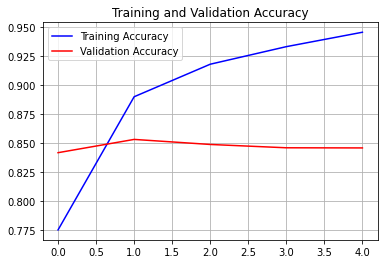

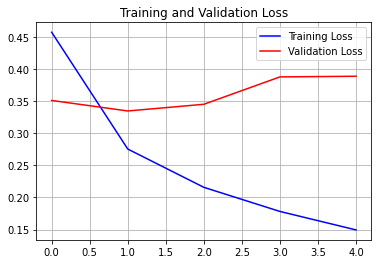

In [150]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, label = 'Training Accuracy', color = 'blue')
plt.plot(epochs, val_acc, label = 'Validation Accuracy', color = 'red')
plt.grid('on')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, label = 'Training Loss', color = 'blue')
plt.plot(epochs, val_loss, label = 'Validation Loss',color = 'red')
plt.grid('on')
plt.title('Training and Validation Loss')
plt.legend()

In [154]:
headline = ["My life is great! I want to die!"]
headline = tokenizer.texts_to_sequences(headline)
headline = pad_sequences(headline, maxlen=max_len, padding = padding_type, truncating = trunc_type)

sentiment = model.predict(headline,batch_size=1,verbose = 2)[0]
print(sentiment)

1/1 - 0s
[0.00011603]
